## Word2Vec from Scratch


In [1]:
text = '''Machine learning is the study of computer algorithms that \
improve automatically through experience. It is seen as a \
subset of artificial intelligence. Machine learning algorithms \
build a mathematical model based on sample data, known as \
training data, in order to make predictions or decisions without \
being explicitly programmed to do so. Machine learning algorithms \
are used in a wide variety of applications, such as email filtering \
and computer vision, where it is difficult or infeasible to develop \
conventional algorithms to perform the needed tasks.'''

### Tokenization


In [2]:
import re

def tokenize(text):
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return pattern.findall(text.lower())
  
tokens = tokenize(text)


In [3]:
def mapping(tokens):
    word_to_id = {}
    id_to_word = {}
    
    for i, token in enumerate(set(tokens)):
        word_to_id[token] = i
        id_to_word[i] = token
    
    return word_to_id, id_to_word

word_to_id, id_to_word = mapping(tokens)
word_to_id

{'a': 19,
 'algorithms': 33,
 'and': 46,
 'applications': 13,
 'are': 0,
 'artificial': 57,
 'as': 23,
 'automatically': 32,
 'based': 44,
 'being': 9,
 'build': 4,
 'computer': 42,
 'conventional': 2,
 'data': 14,
 'decisions': 8,
 'develop': 29,
 'difficult': 11,
 'do': 26,
 'email': 25,
 'experience': 12,
 'explicitly': 47,
 'filtering': 50,
 'improve': 27,
 'in': 16,
 'infeasible': 40,
 'intelligence': 6,
 'is': 17,
 'it': 20,
 'known': 10,
 'learning': 39,
 'machine': 43,
 'make': 41,
 'mathematical': 53,
 'model': 52,
 'needed': 51,
 'of': 38,
 'on': 1,
 'or': 5,
 'order': 58,
 'perform': 28,
 'predictions': 34,
 'programmed': 59,
 'sample': 45,
 'seen': 55,
 'so': 37,
 'study': 30,
 'subset': 21,
 'such': 22,
 'tasks': 31,
 'that': 24,
 'the': 3,
 'through': 36,
 'to': 56,
 'training': 15,
 'used': 48,
 'variety': 7,
 'vision': 35,
 'where': 54,
 'wide': 18,
 'without': 49}

##Generating Training Data


In [4]:
import numpy as np

np.random.seed(42)


def generate_training_data(tokens, word_to_id, window):
    X = []
    y = []
    n_tokens = len(tokens)
    
    for i in range(n_tokens):
        idx = concat(
            range(max(0, i - window), i), 
            range(i, min(n_tokens, i + window + 1))
        )
        for j in idx:
            if i == j:
                continue
            X.append(one_hot_encode(word_to_id[tokens[i]], len(word_to_id)))
            y.append(one_hot_encode(word_to_id[tokens[j]], len(word_to_id)))
    
    return np.asarray(X), np.asarray(y)

def concat(*iterables):
    for iterable in iterables:
        yield from iterable

def one_hot_encode(id, vocab_size):
    res = [0] * vocab_size
    res[id] = 1
    return res
X, y = generate_training_data(tokens, word_to_id, 2)
print(X.shape,y.shape)



(330, 60) (330, 60)


## The Embedding Model

In [5]:
def init_network(vocab_size, n_embedding):
    model = {
        "w1": np.random.randn(vocab_size, n_embedding),
        "w2": np.random.randn(n_embedding, vocab_size)
    }
    return model
model = init_network(len(word_to_id), 10)

In [6]:
def forward(model, X, return_cache=True):
    cache = {}
    
    cache["a1"] = X @ model["w1"]
    cache["a2"] = cache["a1"] @ model["w2"]
    cache["z"] = softmax(cache["a2"])
    
    if not return_cache:
        return cache["z"]
    return cache
def softmax(X):
    res = []
    for x in X:
        exp = np.exp(x)
        res.append(exp / exp.sum())
    return res

In [7]:
(X @ model["w1"]).shape


(330, 10)

In [8]:
(X @ model["w1"] @ model["w2"]).shape


(330, 60)

In [9]:
def backward(model, X, y, alpha):
    cache  = forward(model, X)
    da2 = cache["z"] - y
    dw2 = cache["a1"].T @ da2
    da1 = da2 @ model["w2"].T
    dw1 = X.T @ da1
    assert(dw2.shape == model["w2"].shape)
    assert(dw1.shape == model["w1"].shape)
    model["w1"] -= alpha * dw1
    model["w2"] -= alpha * dw2
    return cross_entropy(cache["z"], y)

In [10]:
def cross_entropy(z, y):
    return - np.sum(np.log(z) * y)

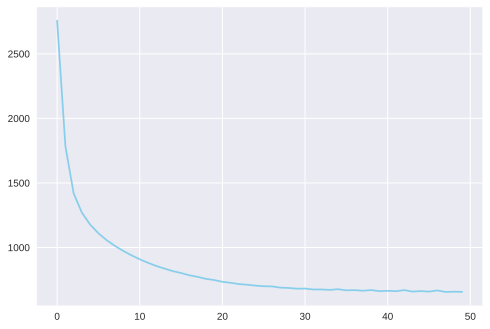

In [11]:
#model performance
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use("seaborn")

n_iter = 50
learning_rate = 0.05

history = [backward(model, X, y, learning_rate) for _ in range(n_iter)]

plt.plot(range(len(history)), history, color="skyblue")
plt.show()

In [12]:
learning = one_hot_encode(word_to_id["learning"], len(word_to_id))
result = forward(model, [learning], return_cache=False)[0]

for word in (id_to_word[id] for id in np.argsort(result)[::-1]):
    print(word)

machine
algorithms
so
intelligence
build
are
the
used
is
learning
infeasible
computer
order
conventional
to
do
artificial
perform
training
a
subset
needed
develop
wide
difficult
it
predictions
in
programmed
improve
that
automatically
study
variety
of
seen
applications
data
where
experience
tasks
without
make
model
sample
vision
such
through
explicitly
mathematical
or
decisions
and
based
email
known
on
as
being
filtering


In [13]:
def get_embedding(model, word):
    try:
        idx = word_to_id[word]
    except KeyError:
        print("`word` not in corpus")
    one_hot = one_hot_encode(idx, len(word_to_id))
    return forward(model, one_hot)["a1"]

In [14]:
get_embedding(model, "learning")


array([-0.74289419, -1.49039724, -0.19076983,  1.07908429,  1.1379953 ,
       -0.65234609, -0.74105042,  1.89446241,  0.01030275,  0.33573272])